# Finite Element Method in 1D

1. Linear ($k=1$) Finite Element Method solver for the 1D Poisson problem:

$-u''=f \quad \in \Omega=(a,b)^2$

$u(a)=0=u(b)$

Import usual modules

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import eigsh

FEM system assembly with trapezoidal rule for rhs

In [102]:
def FEM1_1D_TRAP(omega,N,rhs):
  # 1D FEM with k=1 system matrix and rhs for
  # diffusion problem with homogeneous Dirichlet bc
  # trapezoidal rule uniform grid

  # grid is defined here as uniform
  h = (omega[1]-omega[0]) / N
  x = np.linspace(omega[0],omega[1],N+1)

  # initialise system
  A = sp.lil_matrix((N+1,N+1))
  F = np.zeros(N+1)

  # Assembly loop
  for i in range(N):
    # local contributions
    A_ele = np.matrix([[1/h, -1/h],[-1/h, 1/h]])
    F_ele = 0.5 * h * rhs(x[i:i+2])
    # Assembly local-to-global
    A[i:i+2,i:i+2] += A_ele
    F[i:i+2] += F_ele

  # Apply boundary conditions
  A[0,0] = 1/h; A[0,1] = 0; F[0] = 0
  A[N,N] = 1/h; A[N,N-1] = 0; F[N] = 0

  # return system matrix and rhs vector
  return A, F

Define FEM problem and solve

8.225076221068939e-05


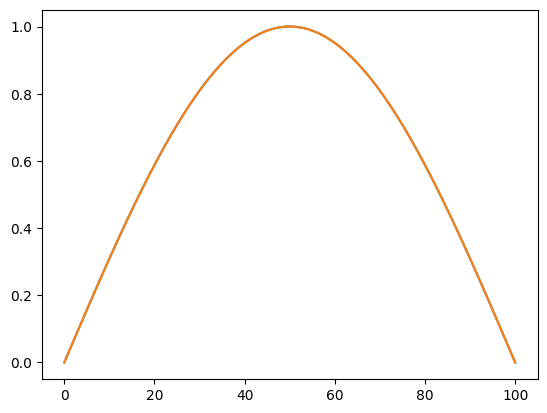

In [103]:
# problem's data
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

# number of subdivisions
N=100;

# call function computing FEM system
A, F = FEM1_1D_TRAP(omega,N,rhs)

# solve
A = A.tocsr()
Uh = sp.linalg.spsolve(A,F)

# Evaluate exact solution at grid nodes
x = np.linspace(omega[0],omega[1],N+1)
U = exact(x)

# Plot solutions
plt.plot(Uh)
plt.plot(U)

# compute discrete max norm error
print(max(abs(U-Uh)))

2. Repeat exercise but for the non-homogeneous Dirichlet conditions, so:

$-u''=f \quad \in \Omega=(a,b)^2$

$u(a)=g(a)$ and $u(b)=g(b)$

for $g$ a given function.

Also:
- allow for nonuniform grid
- use reference element to assemble
- to compute the rhs, use arbitrary order Gauss integration

In [104]:
# Gauss quadrature formula on [0,1]
def quadrature(n_quadrature_points):

  # exploit numpy Gauss quadrature. This is defined in [-1,1]
  q, w = np.polynomial.legendre.leggauss(n_quadrature_points)

  return (q+1)/2, w/2

Function defining the mesh

In [105]:
def mesh(omega,N):
  return np.linspace(omega[0],omega[1],N+1)

Define reference element transformation of coordinates

In [106]:
# Transformation of coordinates functions:
# reference element -> current element
# [0,1] -> [q[i], q[i+1]]

def mapping(q, i):
    # check index is within range
    assert i < len(q)-1
    assert i >= 0
    return lambda x: q[i] + (q[i+1]-q[i]) * x


def mapping_J(q,i):
    assert i < len(q)-1
    assert i >= 0
    return q[i+1]-q[i]


# Linear lagrange basis on reference element
def basis1(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      phi = lambda x: 1-x
    else:
      phi = lambda x: x
    return phi


# Linear lagrange basis derivatives on reference element
def basis1_derivative(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      dphi = lambda x: -np.ones(len(x))
    else:
      dphi = lambda x: np.ones(len(x))
    return dphi



FEM system assembly with Gauss integration



In [107]:
def FEM1_1D_GAUSS(omega,N,n_qpoints,rhs):
  # 1D FEM with k=1 system matrix and rhs
  # not accounting for boundary conditions

  # grid
  vertices = mesh(omega,N)

  # quadrature formula on reference element
  q, w = quadrature(n_qpoints)

  # Evaluation of the two local linear Lagrange basis
  phi = np.array([basis1(i)(q) for i in range(2)]).T
  dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T

  # initialise system
  A = sp.lil_matrix((N+1, N+1))
  F = np.zeros(N+1)

  # Assembly loop
  for i in range(N):
    JxW = mapping_J(vertices,i) * w
    A_ele = np.einsum('qi,qj,q',dphi,dphi,JxW) / mapping_J(vertices,i)**2
    F_ele = np.einsum('qi,q,q',phi,rhs(mapping(vertices,i)(q)),JxW)

    A[i:i+2,i:i+2] += A_ele
    F[i:i+2] += F_ele


  # return system matrix and rhs vector
  return A, F

Function implementing the boundary (nonhomogeneous) Dirichlet conditions. (Similar to FD code, but boundary condition given by sunction $g$!)

In [108]:
def apply_boundary_conditions(omega,N, A, F, g):
    A[0,0] = 1; A[0,1] = 0; F[0] = g(omega[0])
    A[N,N] = 1; A[N,N-1] = 0; F[N] = g(omega[1])



Define FEM problem and solve

4.1126903210453314e-05


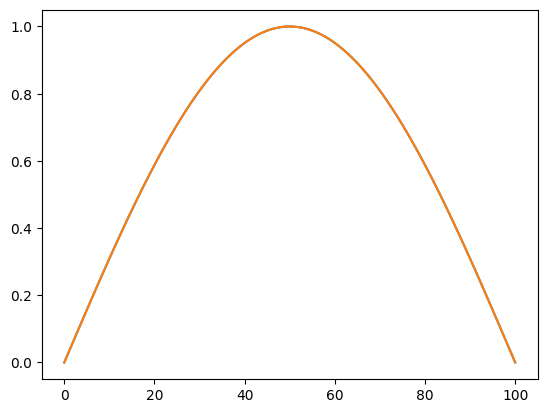

In [109]:
# problem's data
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

# number of subdivisions
N=100

n_qpoints = 1

# call function computing FEM system
A, F = FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)
apply_boundary_conditions(omega,N, A, F, exact)

# solve
A = A.tocsr()
Uh = sp.linalg.spsolve(A,F)

# Evaluate exact solution at grid nodes
x = np.linspace(omega[0],omega[1],N+1)
U = exact(x)

# Plot solutions
plt.plot(Uh)
plt.plot(U)

# compute discrete max norm error
print(max(abs(U-Uh)))


Next we run few experiment to confirm the theoretical convergence and growth of the condition number.

In [110]:
# problem's data
omega = [0,1]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

# number of experiment
no_experiments = 7
# Initialise error vector
Err = np.zeros(7)
NN = np.zeros(7)
Cond = np.zeros(7)


# experiments loop
for i in range(no_experiments):
  # double number of partitions
  N = 2**(i+2)
  NN[i] = N
  n_qpoints = 5

  # call function computing FEM system
  A, F = FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)
  apply_boundary_conditions(omega,N, A, F, exact)

  # solve
  Uh = sp.linalg.spsolve(A,F)

  # condition number of Stiffness matrix
  Cond[i] = np.linalg.cond(A.todense(),p=2)

  # Evaluate exact solution at grid nodes
  vertices = mesh(omega,N)
  U =exact(vertices)

  # Compute errors
  Err[i] = max(abs(U-Uh))



/opt/homebrew/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


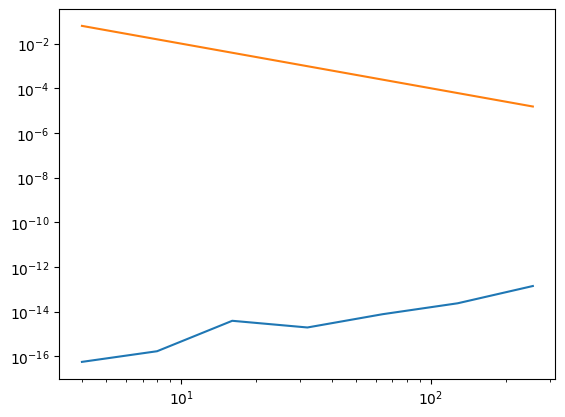

In [111]:
# Plot error
plt.loglog(NN,Err)
plt.loglog(NN,NN**(-2))

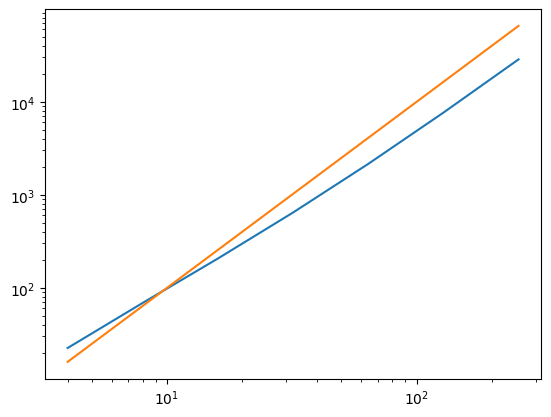

In [112]:
# Plot condition number
plt.loglog(NN,Cond)
plt.loglog(NN,NN**(2))

**Exercise 1** Write a function computing $H^1$-norm error

In [113]:
def FEM1_H1(omega,N,n_qpoints,Uh,sol):
  # H1 error

  # grid
  vertices = mesh(omega,N)
  
  # quadrature formula on reference element
  q, w = quadrature(n_qpoints)
  
  # Evaluation of linear Lagrange basis and derivatives
  dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T

  # initialise value of norm of error
  h1_error = 0.0

  # Assembly error
  for i in range(N):
    # Mapping of quadrature points to current element
    JxW = mapping_J(vertices,i) * w
    mapped_q = mapping(vertices,i)(q)
    
    # Exact derivative evaluation at quadrature points
    exact_derivative = sol(mapped_q)
    
    # Numerical derivative evaluation on current element
    uh_derivative = np.dot(Uh[i:i+2],dphi.T) / mapping_J(vertices,i)
    
    # Error evaluation
    h1_error += np.sum(JxW * (exact_derivative - uh_derivative)**2)
    
  # Return error
  return np.sqrt(h1_error)
  


and test convergence this time for $\| u - u_h \|_{H^1(a,b)}$.

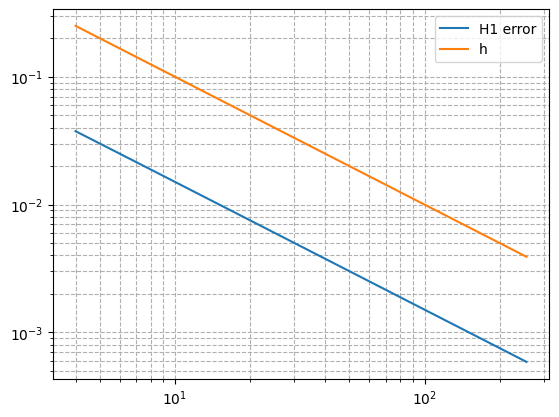

In [ ]:
# problem's data
omega = [0,1]
rhs = lambda x: np.sin(x)
exact_derivative = lambda x: np.cos(x)

# number of experiment
no_experiments = 7
# Initialise error vector
Err = np.zeros(no_experiments)
NN = np.zeros(no_experiments)

# experiments loop
for i in range(no_experiments):
  # double number of partitions
  N = 2**(i+2)
  NN[i] = N
  n_qpoints = 5

  # call function computing FEM system
  A, F = FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)
  apply_boundary_conditions(omega,N, A, F, exact)

  # solve
  Uh = sp.linalg.spsolve(A,F)

  # Evaluate H1 error
  Err[i] = FEM1_H1(omega,N,n_qpoints,Uh,exact_derivative)
  
# Plot error
plt.loglog(NN,Err, label='H1 error')
plt.loglog(NN,NN**(-1), label='h')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

**Exercise 2**: Try same exercise, this time with nonuniform grid

In [115]:
# Function to define a non-uniform grid
def non_uniform_mesh(omega,N):
    # Define a non-uniform grid with vertices clustered at the boundaries and at the center
    x = np.linspace(0,1,N+1)
    x_mapped = 0.5 * (1 - np.cos(x * np.pi))
    x_mapped_centered = x_mapped + 0.05 * np.sin(2 * np.pi * x)
    return omega[0] + (omega[1]-omega[0]) * x_mapped_centered


In [116]:
def FEM1_1D_GAUSS_MOD(omega,N,n_qpoints,rhs):
  # 1D FEM with k=1 system matrix and rhs
  # not accounting for boundary conditions

  # grid
  vertices = non_uniform_mesh(omega,N)

  # quadrature formula on reference element
  q, w = quadrature(n_qpoints)

  # Evaluation of the two local linear Lagrange basis
  phi = np.array([basis1(i)(q) for i in range(2)]).T
  dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T

  # initialise system
  A = sp.lil_matrix((N+1, N+1))
  F = np.zeros(N+1)

  # Assembly loop
  for i in range(N):
    JxW = mapping_J(vertices,i) * w
    A_ele = np.einsum('qi,qj,q',dphi,dphi,JxW) / mapping_J(vertices,i)**2
    F_ele = np.einsum('qi,q,q',phi,rhs(mapping(vertices,i)(q)),JxW)

    A[i:i+2,i:i+2] += A_ele
    F[i:i+2] += F_ele


  # return system matrix and rhs vector
  return A, F

def apply_boundary_conditions(omega,N, A, F, g):
    A[0,0] = 1; A[0,1] = 0; F[0] = g(omega[0])
    A[N,N] = 1; A[N,N-1] = 0; F[N] = g(omega[1])

0.16061734726560484


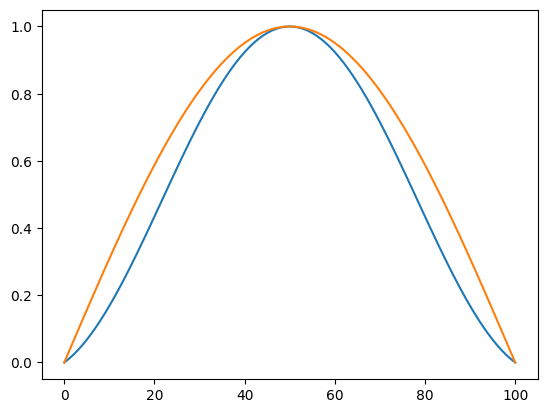

In [117]:
# problem's data
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

# number of subdivisions
N=100

n_qpoints = 1

# call function computing FEM system
A, F = FEM1_1D_GAUSS_MOD(omega,N,n_qpoints,rhs)
apply_boundary_conditions(omega,N, A, F, exact)

# solve
A = A.tocsr()
Uh = sp.linalg.spsolve(A,F)

# Evaluate exact solution at grid nodes
x = np.linspace(omega[0],omega[1],N+1)
U = exact(x)

# Plot solutions
plt.plot(Uh)
plt.plot(U)

# compute discrete max norm error
print(max(abs(U-Uh)))

**Exercise 3**: Write code solving general reaction-advection-diffusion problems

In [118]:
# FEM assembly for general reaction-advection-diffusion problem
def FEM_RAD_1D(omega,N,n_qpoints,rhs,mu,beta,gamma):
    
    # Grid
    vertices = non_uniform_mesh(omega,N)
    
    # Quadrature formula on reference element
    q, w = quadrature(n_qpoints)
    
    # Evaluation of the two local linear Lagrange basis
    phi = np.array([basis1(i)(q) for i in range(2)]).T
    dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T
    
    # Initialise system
    A = sp.lil_matrix((N+1, N+1))
    F = np.zeros(N+1)
    
    # Assembly loop
    for i in range(N):
        JxW = mapping_J(vertices,i) * w
        x_local = mapping(vertices,i)(q)
        
        # Local reaction, advection and diffusion evaluations
        A_diff = mu(x_local) * np.einsum('qi,qj,q',dphi,dphi,JxW) / mapping_J(vertices,i)**2
        A_adv = beta(x_local) * np.einsum('qi,qj,q',phi,dphi,JxW) / mapping_J(vertices,i)
        A_react = gamma(x_local) * np.einsum('qi,qj,q',phi,phi,JxW)
        F_local = np.einsum('qi,q,q',phi,rhs(x_local),JxW)
        
        # Assembly
        A[i:i+2,i:i+2] += A_diff + A_adv + A_react
        F[i:i+2] += F_local
        
    # Return system matrix and rhs vector
    return A, F, vertices

# Boundary conditions
def apply_boundary_conditions(omega,N, A, F, g=(lambda x: 0)):
    A[0,:] = 0; A[0,0] = 1; F[0] = g(omega[0])
    A[N,:] = 0; A[N,N] = 1; F[N] = g(omega[1])

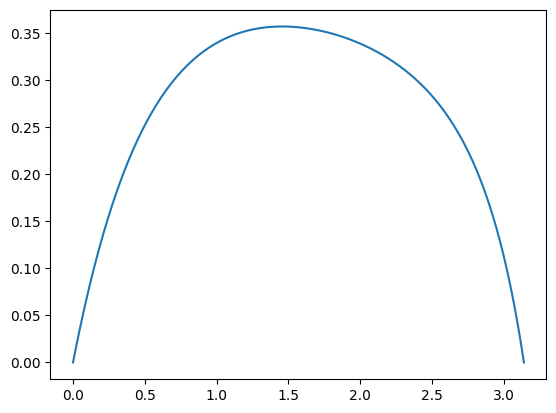

In [119]:
# Problem's data
omega = [0,np.pi]
rhs = lambda x: np.ones(len(x))
mu = lambda x: 1 + np.sin(x)
beta = lambda x: np.ones(len(x))
gamma = lambda x: x
boundary = lambda x: np.zeros(len(x))

# Number of subdivisions
N = 100

n_qpoints = 2

# Call function computing FEM system
A, F, vertices = FEM_RAD_1D(omega,N,n_qpoints,rhs,mu,beta,gamma)
apply_boundary_conditions(omega,N, A, F)

# Solve
A = A.tocsr()
Uh = sp.linalg.spsolve(A,F)

# Plot solution
plt.plot(vertices,Uh, label='FEM solution')